Dataset: RAF-DB
The model architecture consists of three convolutional layers, each followed by max-pooling and dropout, ending with fully connected layers for classification.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

2024-01-31 16:53:35.246787: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
import os
import pandas as pd

# Define paths to your training and testing directories
train_dir = 'Datasets/RAF-DB/DATASET/train'  # Replace with your training directory path
test_dir = 'Datasets/RAF-DB/DATASET/test'    # Replace with your testing directory path

# Function to add images from a directory to a list
def process_directory(directory, data_list):
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)

        # Check if it's a directory
        if os.path.isdir(class_dir):
            # Loop through each image in the folder
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                # Append to the data list
                data_list.append({'filepath': image_path, 'label': class_name})

# Initialize an empty list for storing data
data_list = []

# Add training images to the data list
process_directory(train_dir, data_list)

# Add testing images to the data list
process_directory(test_dir, data_list)

# Create a DataFrame from the list
df = pd.DataFrame(data_list)

# Shuffle the DataFrame
df = df.sample(frac=1).reset_index(drop=True)

# print 15 random samples of the DataFrame
df.sample(15)

,filepath,label
13299,Datasets/RAF-DB/DATASET/test/4/test_0061_align...,4
524,Datasets/RAF-DB/DATASET/train/1/train_07908_al...,1
5347,Datasets/RAF-DB/DATASET/test/4/test_0574_align...,4
6536,Datasets/RAF-DB/DATASET/train/4/train_04422_al...,4
7784,Datasets/RAF-DB/DATASET/train/7/train_09931_al...,7
9014,Datasets/RAF-DB/DATASET/train/5/train_05756_al...,5
11059,Datasets/RAF-DB/DATASET/train/5/train_04650_al...,5
1962,Datasets/RAF-DB/DATASET/train/7/train_10803_al...,7
9377,Datasets/RAF-DB/DATASET/train/5/train_06695_al...,5
9130,Datasets/RAF-DB/DATASET/train/1/train_03226_al...,1


In [13]:
# Define paths to your training and testing directories
# train_dir = 'Datasets/RAF-DB/DATASET/train'
# test_dir = 'Datasets/RAF-DB/DATASET/test'
# train_dir = 'Datasets/FER2013/train'
# test_dir = 'Datasets/FER2013/test'
# Set the image size and batch size
image_size = (96, 96) # Can be increased to improve accuracy or decreased to improve speed. (48, 48) for FER2013, (224, 224) for RAF-DB
batch_size = 32

# Split the data into training, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)  # 80% training, 20% test
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)  # Of the 80% training, split into 60% training and 20% validation

# Calculate and print split ratios
total_samples = len(df)
train_ratio = len(train_df) / total_samples
val_ratio = len(val_df) / total_samples
test_ratio = len(test_df) / total_samples

print(f"Total samples: {total_samples}")
print(f"Training set: {train_ratio:.2f} ({len(train_df)} samples)")
print(f"Validation set: {val_ratio:.2f} ({len(val_df)} samples)")
print(f"Test set: {test_ratio:.2f} ({len(test_df)} samples)\n")

# Create an ImageDataGenerator for data augmentation (optional)
train_datagen = ImageDataGenerator(
    rescale=1./255, # Normalize pixel values to [0, 1]
    # rotation_range=15,  # rotation
    # width_shift_range=0.05, # horizontal shift (only 5% since faces are centered)
    # height_shift_range=0.05, # vertical shift (only 5% since faces are centered)
    # shear_range=0.1, 
    # # zoom_range=0.1,   zoom (with current dataset not needed, since faces are centered)
    # horizontal_flip=True, # flip images horizontally
    # fill_mode='constant', # fill in missing pixels (nearest / constant)
    # brightness_range=[0.8, 1.2] # darken and lighten images
)

val_datagen = ImageDataGenerator(rescale=1./255)  # No augmentation for validation data
test_datagen = ImageDataGenerator(rescale=1./255)  # No augmentation for test data

# Create generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical'
)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)

Total samples: 15339
Training set: 0.60 (9203 samples)
Validation set: 0.20 (3068 samples)
Test set: 0.20 (3068 samples)

Found 9203 validated image filenames belonging to 7 classes.
Found 3068 validated image filenames belonging to 7 classes.
Found 3068 validated image filenames belonging to 7 classes.
{0: 1.3199942627653471, 1: 6.003261578604044, 2: 2.4899891774891776, 3: 0.3661136969407646, 4: 0.9092076664690772, 5: 2.5578098943857697, 6: 0.6886926588340941}


In [6]:
model = Sequential()

# Previous model architecture neurons per layer: 
# 1. Start with images size (e.g. 224 for RAF-DB, 48 for FER2013) and divide by 2 for each convolutional layer
# 2. Pyramidal model: double the number of filters for each convolutional layer, then halve the number of filters for each convolutional layer (e.g. 64, 128, 256, 128, 64)

# First Conv Block
model.add(Conv2D(64, (2, 2), padding='same', activation='relu', input_shape=(96, 96, 1))) # 48 filters, 2x2 kernel size, same padding, relu activation, input shape 48x48x1
model.add(BatchNormalization()) # Batch normalization normalizes the output of a previous activation layer by subtracting the batch mean and dividing by the batch standard deviation
model.add(MaxPooling2D(pool_size=(2, 2))) # Max pooling reduces computation by reducing the dimensionality of the feature maps
model.add(Dropout(0.125))   # Dropout to prevent overfitting. From 0.25

# Second Conv Block
model.add(Conv2D(128, (2, 2), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.125))

# Third Conv Block
model.add(Conv2D(256, (2, 2), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.125))

# Third Conv Block
model.add(Conv2D(128, (2, 2), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.125))

# Third Conv Block
model.add(Conv2D(64, (2, 2), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.125))

# Flatten and Dense Layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25)) # Reduced from 0.5
model.add(Dense(7, activation='softmax'))  # Assuming 7 emotions

model.compile(optimizer=Adam(learning_rate=0.005), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 48, 48, 48)        240       
                                                                 
 batch_normalization_4 (Bat  (None, 48, 48, 48)        192       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 24, 24, 48)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 24, 24, 48)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 24)        4632      
                                                                 
 batch_normalization_5 (Bat  (None, 24, 24, 24)       

In [ ]:
# Early stopping to prevent overfitting. This stops training when the model's performance on the validation set starts to degrade.
early_stopper = EarlyStopping(
    monitor='val_loss',  # Metric to be monitored
    patience=2,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored metric
)

# Create a ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    'model_checkpoint.h5',  # Path where to save the model
    monitor='val_loss',     # Metric to monitor
    save_best_only=False,    # Save only the best model. Set to False to save the model at the end of every epoch so restarting from specific epoch is possible
    save_weights_only=True, # Save only the weights
    mode='min',             # Minimize the monitored metric (val_loss)
    verbose=1               # Verbose output
)

In [7]:
# Load the last saved weights
# model.load_weights('model_checkpoint.h5')

epochs = 10  # When resuming training, set epochs to the total number of epochs you want to train, not just the additional epochs. The model.fit() method continues training for the specified number of epochs, starting from the current epoch count. Typically, 10 to 100 epochs are used. Start with e.g. 30-50.

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    class_weight=class_weights_dict,
    callbacks=[early_stopper, checkpoint]
)

Epoch 1/8
448/448 [==============================] - 311s 692ms/step - loss: 2.0379 - accuracy: 0.2247 - val_loss: 2.4449 - val_accuracy: 0.2199
Epoch 2/8
448/448 [==============================] - 556s 1s/step - loss: 1.7837 - accuracy: 0.2770 - val_loss: 1.6665 - val_accuracy: 0.3398
Epoch 3/8
448/448 [==============================] - 579s 1s/step - loss: 1.7098 - accuracy: 0.3136 - val_loss: 1.5778 - val_accuracy: 0.3863
Epoch 4/8
448/448 [==============================] - 580s 1s/step - loss: 1.6538 - accuracy: 0.3444 - val_loss: 1.5204 - val_accuracy: 0.4222
Epoch 5/8
448/448 [==============================] - 559s 1s/step - loss: 1.5978 - accuracy: 0.3715 - val_loss: 1.9428 - val_accuracy: 0.2979
Epoch 6/8
355/448 [======================>.......] - ETA: 1:51 - loss: 1.5719 - accuracy: 0.3832


KeyboardInterrupt



113/113 [==============================] - 68s 597ms/step - loss: 2.0417 - accuracy: 0.2979
Test accuracy:  0.29785454273223877
113/113 [==============================] - 63s 539ms/step
Classification Report
              precision    recall  f1-score   support

       angry       0.10      0.01      0.01       958
     disgust       0.00      0.00      0.00       111
        fear       0.17      0.02      0.04      1024
       happy       0.25      0.90      0.39      1774
     neutral       0.19      0.04      0.06      1233
         sad       0.08      0.00      0.01      1247
    surprise       0.10      0.04      0.06       831

    accuracy                           0.24      7178
   macro avg       0.13      0.14      0.08      7178
weighted avg       0.16      0.24      0.12      7178


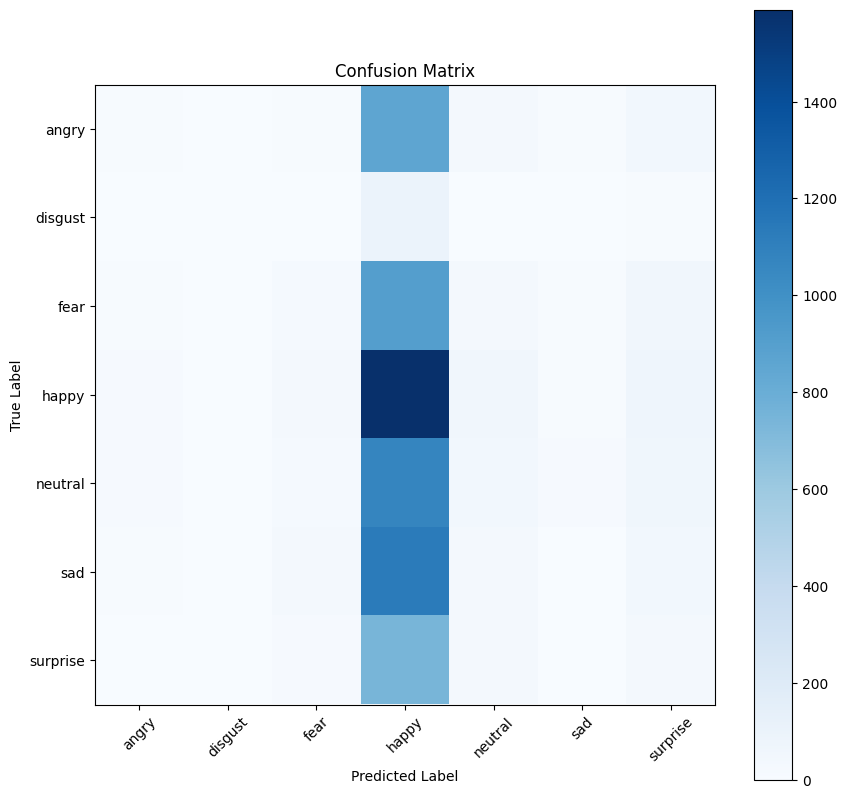

NameError: name 'history' is not defined

In [8]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))
print("Test accuracy: ", test_accuracy)

# Predictions on the test set
test_generator.reset() # Ensuring the generator is reset to the beginning
predictions = model.predict(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))
predicted_classes = np.argmax(predictions, axis=1) # Convert predictions to class labels

# Since the generator omits some samples due to rounding down in 'steps', we trim 'true_classes' to match 'predicted_classes' length
true_classes = test_generator.classes
true_classes = true_classes[:len(predicted_classes)]

class_labels = list(test_generator.class_indices.keys())

# Classification report
print("Classification Report")
print(classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Conducting error analysis
This can be done by examining misclassified examples, which can provide insights into what types of errors the model is making

In [ ]:
# Learning Curves
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Precsion-Recall Curve
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

# Binarize the labels for multi-class
y_bin = label_binarize(true_classes, classes=np.arange(len(class_labels)))
n_classes = y_bin.shape[1]

# Compute precision-recall curve for each class
precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_bin[:, i], predictions[:, i])

# Plot the precision-recall curve
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label='Class {}'.format(class_labels[i]))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.title("Precision vs. Recall curve")
plt.show()


In [ ]:
# ROC Curve and AUC
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='Class {} (area = {:.2f})'.format(class_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
